# Model Haar interferometer with squeezed states, with training on particle number

We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to maximize the sum of photons in modes 0 and 1, 
as n0+n1

We have zero displacement here


Hence training does not alter the probability of events, as each photon has zero mean photons

Here training the squeezing parameters is allowed

nonlinearxwaves@gmail.com<br>
@created 8 February 2021<br>
@version 1 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=4)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dimension

In [7]:
N = 12

In [8]:
n=np.floor_divide(N,2)

In [9]:
nmodes = int(n)

In [10]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [11]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [12]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [13]:
HAAR=ps.HaarLayerConstant(N)

In [14]:
R=ps.RandomLayer(N) # trainable layer

## Displacer

In [15]:
#D=ps.TrainableDisplacementLayer(np.ones((N,1),dtype=np_real))

In [16]:
D=ps.DisplacementLayerConstant(np.zeros((N,1),dtype=np_real))

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [17]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=True)(x1,a1)
x1, a1=D(x1,a1)    
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [18]:
model.input_shape[1]

12

In [19]:
#model.summary()

## Photon counter layer 

Dummy input

In [20]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [21]:
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[0.99612093 0.996120453 0.996120691 0.996120214 0.99612093 0.996120334]]


## Model with the target output to train

Model with the custom ouput to train

In [22]:
n_out0=tf.gather(tf.squeeze(n_out),0) #check this
n_out1=tf.gather(tf.squeeze(n_out),1)
min_out=tf.exp(-n_out0-n_out1)
Train_model = tf.keras.Model(inputs = xin, outputs=min_out) # define the model with inputs and ouputs

Define the custom loss to train the model for maximum output

In [23]:
def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
    return yp

In [24]:
Train_model.compile(loss=custom_loss, optimizer='Adam')

# Transform model

In [25]:
kin, Qrho =ps.getQTransformModel(model)

In [26]:
Qrho.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 84
Non-trainable params: 156
_________________________________________________________________


# Test the Pr operator 

Probability of zero photon

In [27]:
ps.Pr([0]*nmodes, Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1257]], dtype=float32)>

Probability of two photons

In [28]:
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
ps.Pr(nbar, Qrho)

[2, 0, 0, 0, 0, 0]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0047], dtype=float32)>

# Generate all the possible photon patterns assuming max one photon per mode

In [29]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [30]:
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15


## Make a plot versus the probability

Build an array of photon number sampling

In [31]:
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
Computed by the neural network: 0.00070048403
--------------------
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
Computed by the neural network: 0.012078259
--------------------
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
Computed by the neural network: 0.0013435557
--------------------
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
Computed by the neural network: 0.021151174
--------------------
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
Computed by the neural network: 0.018125365
--------------------
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
Computed by the neural network: 0.0038935747
--------------------
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
Computed by the neural network: 0.008367579
--------------------
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
Computed by the neural network: 0.0010011066
--------------------
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
Computed by the neural network: 0.001523871
--------------------
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
Computed by the neural network: 0.031536277
--------------------
Sampl

/home/claudio/.local/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


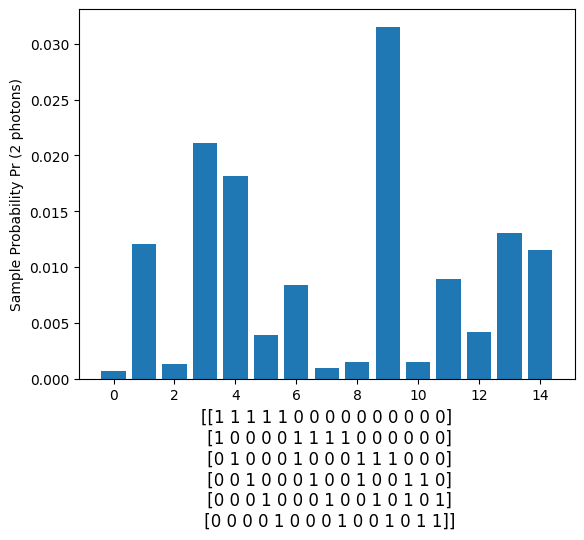

In [32]:
#plt.bar(xaxis,Pn)
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');

#plt.savefig('BS7pairsnotraining.eps', format='eps')


## Patterns with 4 photons

In [33]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
0.0014246674
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.0004138461
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
6.844514e-05
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.0011321031
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.0012474039
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.00042609917
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
0.0031744195
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
0.00073550007
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
0.00013775761
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
0.0033013825
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
0.00094814657
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
0.0017155434
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
0.0006594269
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
0.0008674107
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
0.004122193
Done


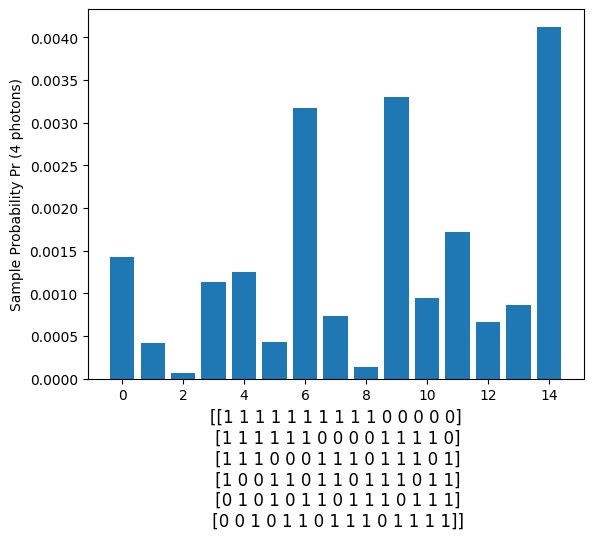

In [34]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');

## Compute the probability of pairs 

In [35]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.12573017179965973 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.0007004840299487114 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.012078259140253067 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.001343555748462677 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.02115117385983467 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.018125364556908607 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.0038935746997594833 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.00836757943034172 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.0010011065751314163 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.001523870974779129 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0315362773835659 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.001499580917879939 pattern (0, 0, 1, 0, 1, 0)
Pho

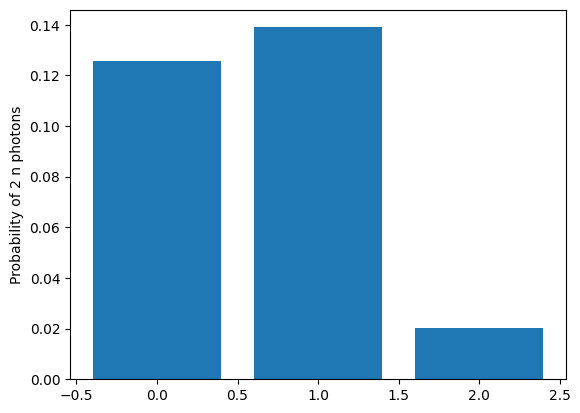

In [36]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

# Train the model and recompute probabilities

In [37]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=10000,verbose=0)

CPU times: user 56.9 s, sys: 2.4 s, total: 59.3 s
Wall time: 32.5 s


Plot training history

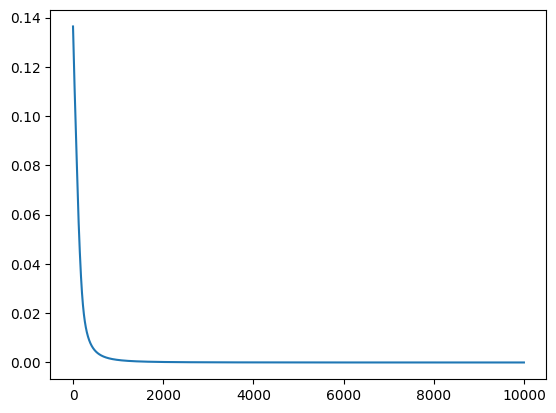

In [38]:
plt.plot(history.history['loss'])

## Recompute the transform after training

In [39]:
kin, Qrho =ps.getQTransformModel(model)

## Patterns with 2 photons

In [40]:
%%time
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.0007413047
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
6.0535967e-09
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
2.73576e-08
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
1.6763806e-08
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
9.313226e-10
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
4.656613e-10
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
6.519258e-09
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
3.7252903e-09
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
2.3283064e-10
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.0019642739
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.0045757247
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.00036133645
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.006043914
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.00019193953
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0003822141
Done
CPU times: user 1.4 s, sys: 3.9 ms, total: 1.4 s
Wall time: 1.4 s


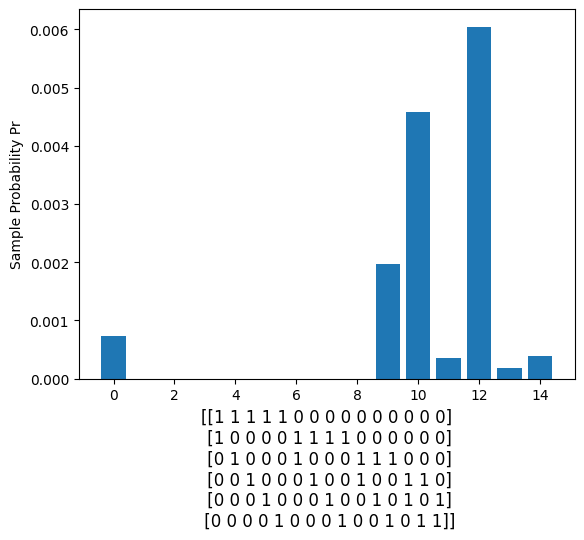

In [41]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');

## Patterns of 4 photons

In [42]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
6.312586e-05
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.00014705097
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
1.1610122e-05
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.00019424097
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
6.1698374e-06
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
1.2284734e-05
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
1.9615982e-08
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
-1.204171e-09
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
2.9758667e-09
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
3.5288394e-09
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
4.132744e-09
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
-8.0035534e-11
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
-2.6484486e-09
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
-1.4842954e-09
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
0.00016028414
Done
CPU times: user 52.2 s, sys: 17.5 ms, total: 52.2 s
Wall time: 52.2 s


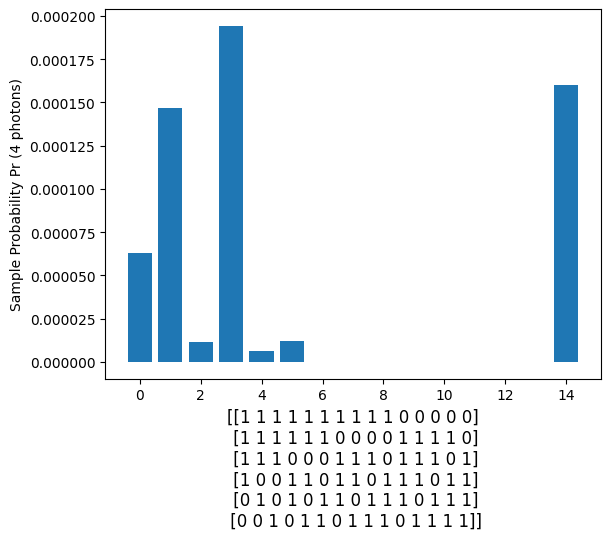

In [43]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr (4 photons)');

# Check the weights of layers

In [44]:
model.layers

In [45]:
tf.print(model.layers[2].get_M())

([[0.248335317 -0.179506809 -0.166207269 ... 0.137745067 0.194327667 -0.736356378]
 [0.179506809 0.248335317 0.283317208 ... 0.33450529 0.736356378 0.194327667]
 [0.227312014 -0.0232646689 0.139772475 ... -0.287882805 -0.355988473 0.207954556]
 ...
 [0.307345271 -0.494974464 0.655879378 ... -0.0121105015 -0.0363686085 0.128971]
 [-0.0821964741 -0.31772691 0.00333230197 ... -0.618720949 0.40125668 -0.0240808874]
 [0.31772691 -0.0821964741 -0.191937298 ... 0.216696233 0.0240808874 0.40125668]], [[0.248335317 0.179506809 0.227312014 ... 0.307345271 -0.0821964741 0.31772691]
 [-0.179506809 0.248335317 -0.0232646689 ... -0.494974464 -0.31772691 -0.0821964741]
 [-0.166207269 0.283317208 0.139772475 ... 0.655879378 0.00333230197 -0.191937298]
 ...
 [0.137745067 0.33450529 -0.287882805 ... -0.0121105015 -0.618720949 0.216696233]
 [0.194327667 0.736356378 -0.355988473 ... -0.0363686085 0.40125668 0.0240808874]
 [-0.736356378 0.194327667 0.207954556 ... 0.128971 -0.0240808874 0.40125668]])


# Compute the statistical probability of pairs

In [46]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.023066610097885132 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.0007413047133013606 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=6.05359673500061e-09 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=2.735760062932968e-08 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=1.6763806343078613e-08 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=9.313225746154785e-10 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=4.656612873077393e-10 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=6.51925802230835e-09 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=3.725290298461914e-09 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=2.3283064365386963e-10 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.001964273862540722 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.004575724713504314 pattern (0, 0, 1, 0

In [47]:
probn

array([0.0231, 0.0143, 0.0006])

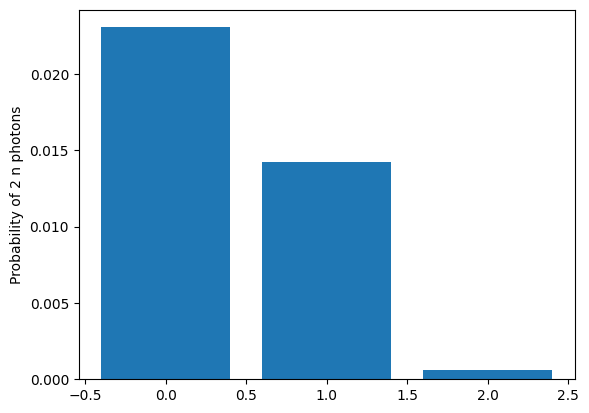

In [48]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 n photons');

Looks that the overall probability does not change, but most of the couples appears in the target modes

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

In [50]:
model.layers[3].r

<tf.Variable 'single_mode_squeezer_layer/r:0' shape=() dtype=float32, numpy=1.0031285>

In [51]:
model.layers[3].theta

<tf.Variable 'single_mode_squeezer_layer/theta:0' shape=() dtype=float32, numpy=0.7853087>

In [52]:
model.layers[4].r

<tf.Variable 'single_mode_squeezer_layer_1/r:0' shape=() dtype=float32, numpy=1.7895045>

In [53]:
model.layers[4].theta

<tf.Variable 'single_mode_squeezer_layer_1/theta:0' shape=() dtype=float32, numpy=0.7854601>

In [54]:
model.layers[5].r

<tf.Variable 'single_mode_squeezer_layer_2/r:0' shape=() dtype=float32, numpy=0.98030645>

In [55]:
model.layers[6].r

<tf.Variable 'single_mode_squeezer_layer_3/r:0' shape=() dtype=float32, numpy=0.94476604>

In [56]:
model.layers[7].r

<tf.Variable 'single_mode_squeezer_layer_4/r:0' shape=() dtype=float32, numpy=1.6177799>

In [57]:
model.layers[8].r

<tf.Variable 'single_mode_squeezer_layer_5/r:0' shape=() dtype=float32, numpy=1.0014298>